## Imports

In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Download data

In [ ]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

In [ ]:
ls ibug_300W_large_face_landmark_dataset

afw/    image_metadata_stylesheet.xsl  labels_ibug_300W.xml
helen/  labels_ibug_300W_test.xml      lfpw/
ibug/   labels_ibug_300W_train.xml


## Visualization

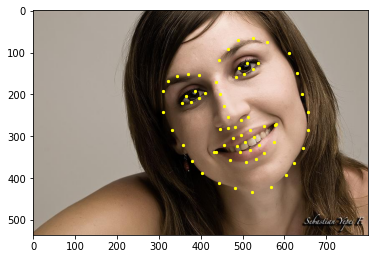

In [ ]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/1030333538_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for p in points:
  x, y = p.split(' ')
  landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(6, 6))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/1030333538_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'yellow')
plt.show()

## Dataset Creation

In [ ]:
class FaceLandmarkDataset(Dataset):

  def __init__(self, transform=None):

    tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
    root = tree.getroot()

    self.img_filenames = []
    self.landmarks = []
    self.crops = []
    self.transform = transform
    self.root_dir = 'ibug_300W_large_face_landmark_dataset'

    for filename in root[2]:
      self.img_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

      self.crops.append(filename[0].attrib)

      landmark = []
      for n in range(68):
        x_coor = int(filename[0][n].attrib['x'])
        y_coor = int(filename[0][n].attrib['y'])
        landmark.append([x_coor, y_coor])
      self.landmarks.append(landmark)

    self.landmarks = np.array(self.landmarks).astype('float32')


  def __len__(self):
    return len(self.img_filenames)

  def __getitem__(self, index):
    image = cv2.imread(self.img_filenames[index], 0)
    landmarks = self.landmarks[index]

    if self.transform:
      image, landmarks = self.transform(image, landmarks, self.crops[index])

    landmarks -= 0.5

    return image, landmarks

In [ ]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [ ]:
dataset = FaceLandmarkDataset(Transforms())

## Visualization after tranformation

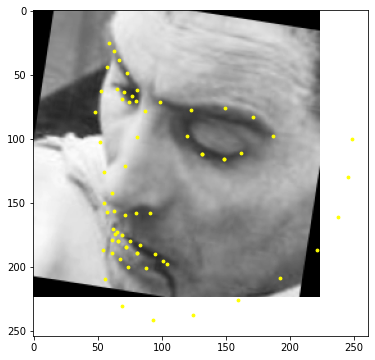

In [ ]:
rnd_idx = np.random.randint(len(dataset))

image, landmarks = dataset[rnd_idx]
landmarks = (landmarks + 0.5) * 224

plt.figure(figsize=(6, 6))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8, c='yellow');

## Train/Val Split

In [ ]:
bs = 64

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes = 136):
        super().__init__()
        self.model_name = 'resnet18'
        self.model = models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
train_loss_history = []
val_loss_history = []

In [ ]:
torch.autograd.set_detect_anomaly(True)
model = Model()
model.cuda()

loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

loss_min = np.inf
epochs = 20

start_time = time.time()

for epoch in range(1, epochs + 1):
  train_loss = 0
  val_loss = 0
  acc_loss = 0

  model.train()

  for step in range(1, len(train_loader) + 1):

    images, landmarks = next(iter(train_loader))

    images = images.cuda()
    landmarks = landmarks.view(landmarks.size(0), -1).cuda()

    pred = model(images)

    optimizer.zero_grad()

    loss_curr = loss(pred, landmarks)

    loss_curr.backward()

    optimizer.step()

    train_loss += loss_curr.item()
    acc_loss += train_loss / step

    print("Train Steps: %d/%d  Loss: %.4f " % (step, len(train_loader), acc_loss))

  model.eval()
  with torch.no_grad():

    for step in range(1, len(valid_loader) + 1):
      
      images, landmarks = next(iter(valid_loader))

      images = images.cuda()
      landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
      pred = model(images)

      # find the loss for the current step
      loss_curr = loss(pred, landmarks)

      val_loss += loss_curr.item()
      acc_loss = val_loss / step

      print("Valid Steps: %d/%d  Loss: %.4f " % (step, len(valid_loader), acc_loss))

  train_loss /= len(train_loader)
  val_loss /= len(valid_loader)

  train_loss_history.append(train_loss)
  val_loss_history.append(val_loss)
  
  print('\n--------------------------------------------------')
  print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, train_loss, val_loss))
  print('--------------------------------------------------')
  
  if val_loss < loss_min:
      loss_min = val_loss
      torch.save(model.state_dict(), f'/content/face_landmarks_{bs}.pth') 
      print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, epochs))
      print('Model Saved\n')
    
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Train Steps: 1/94  Loss: 0.3504 
Train Steps: 2/94  Loss: 0.6678 
Train Steps: 3/94  Loss: 0.9584 
Train Steps: 4/94  Loss: 1.2249 
Train Steps: 5/94  Loss: 1.4688 
Train Steps: 6/94  Loss: 1.6920 
Train Steps: 7/94  Loss: 1.8969 
Train Steps: 8/94  Loss: 2.0852 
Train Steps: 9/94  Loss: 2.2589 
Train Steps: 10/94  Loss: 2.4197 
Train Steps: 11/94  Loss: 2.5694 
Train Steps: 12/94  Loss: 2.7093 
Train Steps: 13/94  Loss: 2.8405 
Train Steps: 14/94  Loss: 2.9638 
Train Steps: 15/94  Loss: 3.0803 
Train Steps: 16/94  Loss: 3.1906 
Train Steps: 17/94  Loss: 3.2953 
Train Steps: 18/94  Loss: 3.3950 
Train Steps: 19/94  Loss: 3.4903 
Train Steps: 20/94  Loss: 3.5813 
Train Steps: 21/94  Loss: 3.6687 
Train Steps: 22/94  Loss: 3.7525 
Train Steps: 23/94  Loss: 3.8333 
Train Steps: 24/94  Loss: 3.9111 
Train Steps: 25/94  Loss: 3.9862 
Train Steps: 26/94  Loss: 4.0589 
Train Steps: 27/94  Loss: 4.1292 
Train Steps: 28/94  Loss: 4.1973 
Train Steps: 29/94  Loss: 4.2635 
Train Steps: 30/94  Los

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-cnqwdi6g'


Train Steps: 4/94  Loss: 0.0101 
Train Steps: 5/94  Loss: 0.0126 
Train Steps: 6/94  Loss: 0.0151 
Train Steps: 7/94  Loss: 0.0176 
Train Steps: 8/94  Loss: 0.0201 
Train Steps: 9/94  Loss: 0.0226 
Train Steps: 10/94  Loss: 0.0251 
Train Steps: 11/94  Loss: 0.0275 
Train Steps: 12/94  Loss: 0.0300 
Train Steps: 13/94  Loss: 0.0325 
Train Steps: 14/94  Loss: 0.0350 
Train Steps: 15/94  Loss: 0.0375 
Train Steps: 16/94  Loss: 0.0400 
Train Steps: 17/94  Loss: 0.0424 
Train Steps: 18/94  Loss: 0.0449 
Train Steps: 19/94  Loss: 0.0474 
Train Steps: 20/94  Loss: 0.0499 
Train Steps: 21/94  Loss: 0.0523 
Train Steps: 22/94  Loss: 0.0548 
Train Steps: 23/94  Loss: 0.0573 
Train Steps: 24/94  Loss: 0.0598 
Train Steps: 25/94  Loss: 0.0623 
Train Steps: 26/94  Loss: 0.0647 
Train Steps: 27/94  Loss: 0.0672 
Train Steps: 28/94  Loss: 0.0697 
Train Steps: 29/94  Loss: 0.0721 
Train Steps: 30/94  Loss: 0.0746 
Train Steps: 31/94  Loss: 0.0770 
Train Steps: 32/94  Loss: 0.0795 
Train Steps: 33/94  

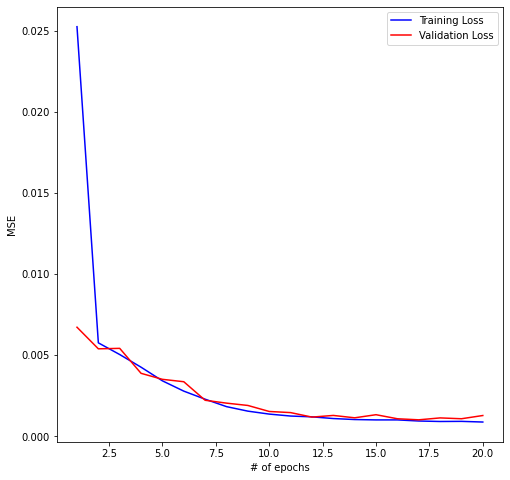

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

axs.plot(np.arange(1, 21), train_loss_history, color='blue', label='Training Loss')
axs.plot(np.arange(1, 21), val_loss_history, color='red', label='Validation Loss')
axs.set_xlabel('# of epochs')
axs.set_ylabel('MSE')

plt.legend()
plt.savefig('loss_graph.png')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
ls

 2022-2023@
'Alibek Kaliyev Audit Results F22.pdf'
 alibek_kaliyev_resume.pdf
 Alibek_Kaliyev_s_CV.pdf
'Alibek Kaliyev SP23 Plan.jpg'
 Books/
 Classes/
'Colab Notebooks'/
'CSBA Projects.gsheet'
 Depression-Severity-Prediction/
'Freshman Academy'/
 Generalizable-Model-Fit/
'Google CSRMP.gdoc'
'Graduate Programs.gsheet'
 GrainBound/
'Internship Docs'/
 Kaliyev-Alibek-Grader-offer-Fall2022.pdf
'Lehigh Documents'/
 Le-laf.gsheet
 Notability/
'Note Oct 16, 2022 (2).pdf'
'ORNL Trip 9_15'@
 Other/
 Pre-trained-Deep-Learning-Models-For-Rapid-Analysis-Of-Piezoelectric-Hysteresis-Loops-SHO-Fitting/
 Projects/
 Quantized-SHO-Fitting/
 Rapid-Fitting-of-BEPFM-and-Hysteresis-Loops-Using-Physics-Constrained-Unsupervised-Neural-Networks/
 Research/
 Resumes/
'Round 5_Feb_22'@
'System Diagram.drawio'
'Technical Resources'/
 Transcript_ALIBEKKALIYEV.pdf


In [ ]:
torch.save(model.state_dict(), f'face_landmarks_{bs}.pth')